In [1]:
%matplotlib inline
from parcels import Field, FieldSet, ParticleSet,Variable, JITParticle, plotTrajectoriesFile, AdvectionRK4,ErrorCode
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc, animation
import xarray as xr
from scipy.special import entr

fatal: not a git repository (or any of the parent directories): .git


In [2]:
def DeleteParticle(particle, fieldset, time):
    """Delete particle from OceanParcels simulation to avoid run failure
    """
    
    print(f'Particle {particle.id} lost !! [{particle.time}, {particle.depth}, {particle.lat}, {particle.lon}]')
    particle.delete()

In [4]:
class MPParticle(JITParticle):
    Kzf = Variable('Kzf', initial =  1.0) 
class MPParticle2(JITParticle):
    Kzf = Variable('Kzf', initial =  0.0) 

In [5]:
def tu_mix(particle,fieldset,time):
    bath= 109.73707
    if particle.lat+0.5 > bath: #Only calculate gradient of diffusion for particles deeper than 0.6 otherwise OP will check for particles outside the domain and remove it.
        Kzdz = 0
    else: 
        Kzdz = 2*(fieldset.Kz[time,particle.depth,particle.lat+0.5, particle.lon]-fieldset.Kz[time,particle.depth, particle.lat, particle.lon]) #forward difference 
    dgrad = Kzdz * particle.dt * particle.Kzf
    if particle.lat+0.5*dgrad > 0.5:
        kk = fieldset.Kz[time,particle.depth, particle.lat+0.5*dgrad, particle.lon] #Vertical diffusivity SSC  #
    else:
        kk = fieldset.Kz[time,particle.depth, 0.5, particle.lon] #Vertical diffusivity SSC  #
    Kx = 1.5
    Rr = ParcelsRandom.uniform(-1, 1)
    Rr2 = ParcelsRandom.uniform(-1, 1)
    d_random = sqrt(3*2*kk*particle.dt) * Rr
    d_randomx = sqrt(3*2*Kx*particle.dt) * Rr2
    Dlayerz = 0.5*sqrt(kk * particle.dt) #1m mixing layer
    Dlayerx = 0.5*sqrt(Kx * particle.dt)
    if particle.lon + d_randomx < 0:
        particle.lon = Dlayerx * ParcelsRandom.uniform(0, 1)
    elif particle.lon + d_randomx > 2e3:
        particle.lon = 2e3 - Dlayerx * ParcelsRandom.uniform(0, 1)
    else: 
        particle.lon=particle.lon + d_randomx
    if d_random + dgrad +particle.lat > bath: #randomly in the water column
        particle.lat = bath - Dlayerz * ParcelsRandom.uniform(0, 1)
    elif d_random +particle.lat +dgrad < 0:
            particle.lat = Dlayerz * ParcelsRandom.uniform(0, 1) #Well mixed boundary layer
    else:
        particle.lat += d_random + dgrad 

In [6]:
Dat = pd.read_csv('ubcSSg3DwGridFields1hV19-05_9244_b1de_6bbd.csv')
depth=np.array(Dat.depth)[1:].astype('float32')
Kz_col=np.array(Dat.vert_eddy_diff)[1:].astype('float32')

In [8]:
dim = 100
dep = len(depth)
lon = np.linspace(0., 2e3, dim, dtype=np.float32)
dep2= np.linspace(0., depth[-1], dim, dtype=np.float32)
#lon_g, depth_g = np.meshgrid(lon,dep2)
U = Field('U', np.zeros((dep, dim), dtype=np.float32), lon=lon, lat=depth)
V = Field('V', np.zeros((dep, dim), dtype=np.float32), lon=lon, lat=depth)
Kz_data = np.zeros((dep, dim), dtype=np.float32)
for i in range(dim):
    Kz_data[:,i]=Kz_col
Kz = Field('Kz', Kz_data, grid=U.grid)

In [10]:
fieldset = FieldSet(U, V)
fieldset.add_field(Kz)

In [11]:
lon_g = np.random.uniform(low=lon[0], high=lon[-1], size=(10*dim,))
depth_g = np.random.uniform(low=depth[0], high=depth[-1], size=(10*dim,))

In [12]:
def run_turb_test(lon_g,depth_g):
    pset = ParticleSet(fieldset, pclass=MPParticle, lon=lon_g, lat=depth_g)
    pset2 = ParticleSet(fieldset, pclass=MPParticle2, lon=lon_g, lat=depth_g)
    output_file = pset.ParticleFile(name='Output.nc', outputdt=50)
    output_file2 = pset2.ParticleFile(name='Output2.nc', outputdt=50)
    KE=AdvectionRK4 + pset.Kernel(tu_mix)
    pset.execute(KE , runtime=5e3, dt=5, output_file=output_file,recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})
    output_file.export()  # export the trajectory data to a netcdf file
    pset2.execute(KE , runtime=5e3, dt=5, output_file=output_file2,recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})
    output_file2.export()  # export the trajectory data to a netcdf file

In [13]:
run_turb_test(lon_g,depth_g)

INFO: Compiled ArrayMPParticleAdvectionRK4tu_mix ==> /var/folders/y1/__7_22kx3n9_rh91qk2htyc00000gn/T/parcels-501/lib7bd3d678b80392ee140e0154324d91ca_0.so
INFO: Compiled ArrayMPParticleAdvectionRK4tu_mix ==> /var/folders/y1/__7_22kx3n9_rh91qk2htyc00000gn/T/parcels-501/lib20fc1dfc3c604b76ac5ec59206b52e83_0.so


In [14]:
dat = xr.load_dataset('Output.nc')
dat2 = xr.load_dataset('Output2.nc')

In [12]:
def anim2(file1,file2,fps=1):  
    box=([0,2e3,2e3,0,0],[0,0,depth[-1],depth[-1],0])
    fig,axs=plt.subplots(1,4,figsize=(15,10))
    axs[0].scatter(dat.lon[:,0],dat.lat[:,0],s=5)
    #ax2 = axs[2].twiny()
    #ax2.plot(Kz_col,depth,c='r')
    axs[3].plot(Kz_col,depth,c='r')
    axs[3].set_title('Vertical profile $K_z$ [$m^2/s$]')
    axs[3].invert_yaxis()
    axs[0].plot(box[0],box[1],c='grey',linewidth=3)
    axs[1].plot(box[0],box[1],c='grey',linewidth=3)
    axs[2].plot(box[0],box[1],c='grey',linewidth=3)
    axs[0].invert_yaxis()
    axs[0].set_title('Initial condition (t: 0s)')
    axs[1].invert_yaxis()
    axs[1].set_title("With $K_z$' correction (t: 5*$10^3$s)")
    axs[2].invert_yaxis()
    axs[2].set_title("Without $K_z$' correction (t: 5*$10^3$s)")
    axs[0].set_ylabel('Depth (m)')

    def update(frame):           
        global ss        
        for scat in ss:              
            scat.remove()            
        ss =[]                    
        ss.append(axs[1].scatter(file1.lon[:,frame],file1.lat[:,frame],s=5,c ='tab:blue'))         
        ss.append(axs[2].scatter(file2.lon[:,frame],file2.lat[:,frame],s=5,c ='tab:blue'))                      
        print(f'{100*frame/len(file1):.2f}% completed')           
        return ss
    return animation.FuncAnimation(fig, update, frames=np.arange(0,100,fps))

In [17]:
ss =[]
ani = anim2(dat,dat2,fps=1)
f = r"/Users/jvalenti/Downloads/mix.gif" 
FFwriter = animation.FFMpegWriter()
ani.save(f, writer = FFwriter)

0.00% completed
0.00% completed
16.67% completed
33.33% completed
50.00% completed
66.67% completed
83.33% completed
100.00% completed
116.67% completed
133.33% completed
150.00% completed
166.67% completed
183.33% completed
200.00% completed
216.67% completed
233.33% completed
250.00% completed
266.67% completed
283.33% completed
300.00% completed
316.67% completed
333.33% completed
350.00% completed
366.67% completed
383.33% completed
400.00% completed
416.67% completed
433.33% completed
450.00% completed
466.67% completed
483.33% completed
500.00% completed
516.67% completed
533.33% completed
550.00% completed
566.67% completed
583.33% completed
600.00% completed
616.67% completed
633.33% completed
650.00% completed
666.67% completed
683.33% completed
700.00% completed
716.67% completed
733.33% completed
750.00% completed
766.67% completed
783.33% completed
800.00% completed
816.67% completed
833.33% completed
850.00% completed
866.67% completed
883.33% completed
900.00% completed
9

In [18]:
from IPython.display import Image
with open(f,'rb') as anim:
     display(Image(anim.read()))

Text(0, 0.5, 'Depth (m)')

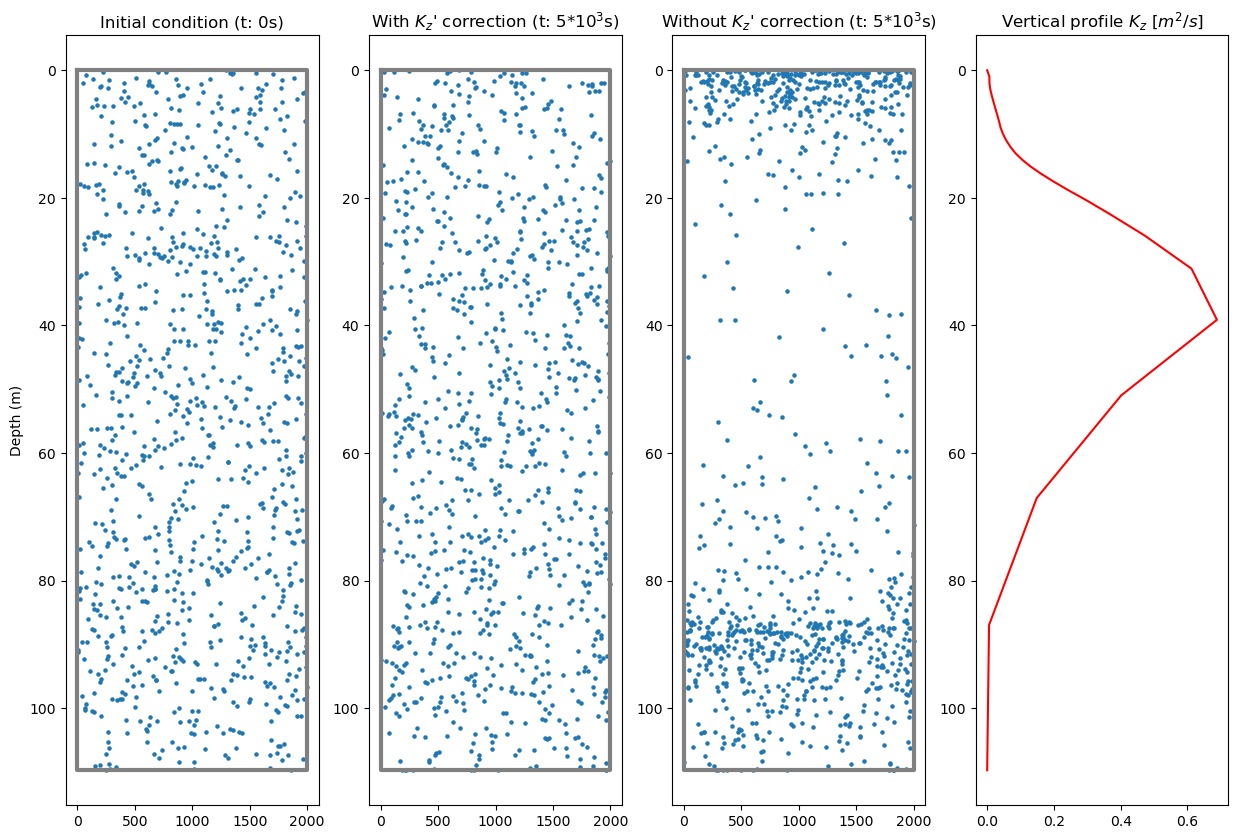

In [19]:
box=([0,2e3,2e3,0,0],[0,0,depth[-1],depth[-1],0])
fig,axs=plt.subplots(1,4,figsize=(15,10))
axs[0].scatter(dat.lon[:,0],dat.lat[:,0],s=5)
#ax2 = axs[2].twiny()
#ax2.plot(Kz_col,depth,c='r')
axs[3].plot(Kz_col,depth,c='r')
axs[3].set_title('Vertical profile $K_z$ [$m^2/s$]')
axs[3].invert_yaxis()
axs[0].plot(box[0],box[1],c='grey',linewidth=3)
axs[1].plot(box[0],box[1],c='grey',linewidth=3)
axs[2].plot(box[0],box[1],c='grey',linewidth=3)
axs[0].invert_yaxis()
axs[0].set_title('Initial condition (t: 0s)')
axs[1].scatter(dat.lon[:,-1],dat.lat[:,-1],s=5)
axs[1].invert_yaxis()
axs[1].set_title("With $K_z$' correction (t: 5*$10^3$s)")
axs[2].scatter(dat2.lon[:,-1],dat2.lat[:,-1],s=5)
axs[2].invert_yaxis()
axs[2].set_title("Without $K_z$' correction (t: 5*$10^3$s)")
axs[0].set_ylabel('Depth (m)')

In [20]:
def entropy(data, bins=100):
    """
        Calculate entropy of multiple varibles (discrete and continous).
        X is a 2d-array, each column is a variable.
    """
    hist = np.histogramdd(data, bins=bins)[0]
    prob = hist/len(data)
    prob[prob == 0] = 1
    log_prob = np.log2(prob)
    

    return -np.sum(np.multiply(prob, log_prob))

In [21]:
def no_nan(x,y):
    no_nan=[]
    no_nan1=[]
    for i,xi in enumerate(x):
        if np.isnan(xi) == False:
            no_nan.append(xi) 
            no_nan1.append(y[i]) 
    return no_nan,no_nan1

d0,l0=no_nan(dat2.lat[:,0],dat2.lon[:,0])
e0=entropy([d0,l0])

In [22]:
import sys, os

# Disable
def blockPrint():
    sys.stdout = open(os.devnull, 'w')

# Restore
def enablePrint():
    sys.stdout = sys.__stdout__

In [23]:
def run_n_test(n):
    e1,e2=[],[]
    for i in range(n):
        lon_g = np.random.uniform(low=lon[0], high=lon[-1], size=(10*dim,))
        depth_g = np.random.uniform(low=depth[0], high=depth[-1], size=(10*dim,))
        run_turb_test(lon_g,depth_g)
        dat = xr.load_dataset('Output.nc')
        dat2 = xr.load_dataset('Output2.nc')
        d0,l0=no_nan(dat2.lat[:,0],dat2.lon[:,0])
        e0=entropy([d0,l0])
        d2,l2=no_nan(dat2.lat[:,-1],dat2.lon[:,-1])
        e2.append(entropy([d2,l2])-e0)
        d1,l1=no_nan(dat.lat[:,-1],dat.lon[:,-1])
        e1.append(entropy([d1,l1])-e0)
    m1=np.mean(e1)
    sd1=np.std(e1)/np.sqrt(n)
    m2=np.mean(e2)
    sd2=np.std(e2)/np.sqrt(n)
    return m1,sd1,m2,sd2

In [24]:
blockPrint()
m1,sd1,m2,sd2=run_n_test(10)
enablePrint()

CTEs = [m1, m2]
error = [sd1, sd2]

INFO: Compiled ArrayMPParticleAdvectionRK4tu_mix ==> /var/folders/y1/__7_22kx3n9_rh91qk2htyc00000gn/T/parcels-501/libb34c83e5cc5da201db6a753f8e7dcb61_0.so
INFO: Compiled ArrayMPParticleAdvectionRK4tu_mix ==> /var/folders/y1/__7_22kx3n9_rh91qk2htyc00000gn/T/parcels-501/lib14b35cadf521a1ea2060503667d215ca_0.so
INFO: Compiled ArrayMPParticleAdvectionRK4tu_mix ==> /var/folders/y1/__7_22kx3n9_rh91qk2htyc00000gn/T/parcels-501/lib1c7e5c2b9dd8c455822434c324491657_0.so
INFO: Compiled ArrayMPParticleAdvectionRK4tu_mix ==> /var/folders/y1/__7_22kx3n9_rh91qk2htyc00000gn/T/parcels-501/libf6bba5e25920c62135c6059d2cc43d24_0.so
INFO: Compiled ArrayMPParticleAdvectionRK4tu_mix ==> /var/folders/y1/__7_22kx3n9_rh91qk2htyc00000gn/T/parcels-501/lib6dc0c8a3cbba4bb09990276f5f708039_0.so
INFO: Compiled ArrayMPParticleAdvectionRK4tu_mix ==> /var/folders/y1/__7_22kx3n9_rh91qk2htyc00000gn/T/parcels-501/libc3cc1bb882e380f3377bd7168cb062ee_0.so
INFO: Compiled ArrayMPParticleAdvectionRK4tu_mix ==> /var/folders/y1/_

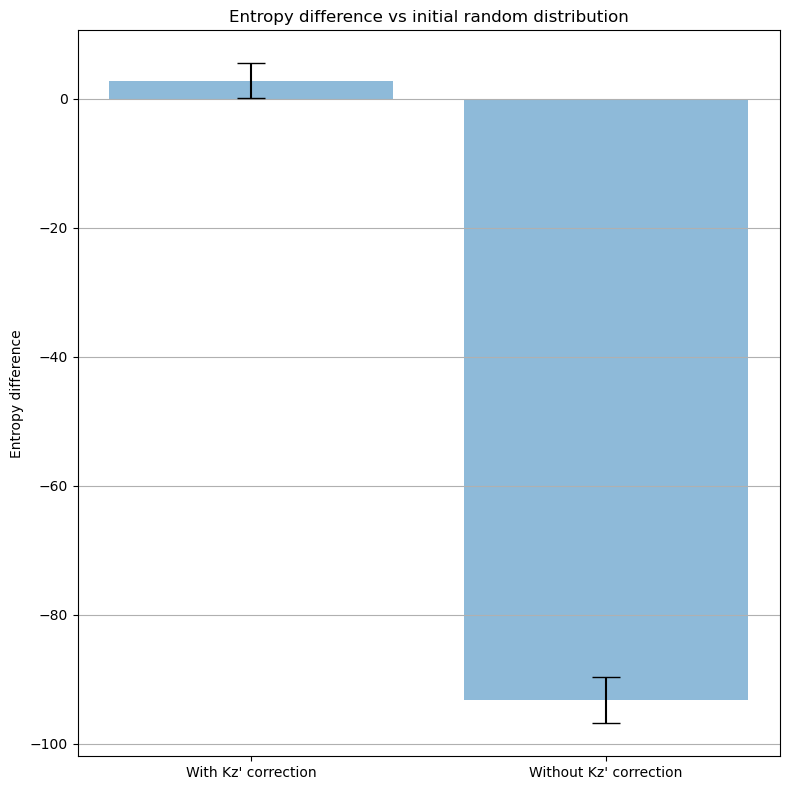

In [25]:
# Build the plot
x_pos=np.arange(2)
fig, ax = plt.subplots(figsize=(8,8))
ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Entropy difference')
ax.set_xticks(x_pos)
ax.set_xticklabels(["With Kz' correction","Without Kz' correction"])
ax.set_title('Entropy difference vs initial random distribution')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()

In [26]:
d2,l2=no_nan(dat2.lat[:,-1],dat2.lon[:,-1])
entropy([d2,l2])-e0

-90.95670149911751

In [27]:
d1,l1=no_nan(dat.lat[:,-1],dat.lon[:,-1])
entropy([d1,l1])-e0

-7.0